## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [157]:
from __future__ import division
import os
import math
import random
import scipy
from pylab import figure
import scipy.stats as stats
import numpy as np
import pymworks
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
%matplotlib inline

### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False # for binning data over normalized session time. if True adds random noise to session_indices so they don't completely overlap if same number of sessions, etc

##### Location of files

In [308]:
# filepaths of data to analyze

# regular stim full learning
filepath_reg_all = '_data/AK_and_AL_Cohorts/10fullcross_experiment/canonical_size_deptrotrl_10fullcross/pickle_files_by_session/'

# regular stim learning
filepath_regular = '_data/AK_and_AL_Cohorts/last10_fullcross/pickle_files_by_session/'

# regular no min RT
filepath_nominrt = '_data/AK_Cohort/6_fullcrossnominrt/pickle_files_by_session/'

# transparent/dim
filepath_transparency = '_data/AK_Cohort/transparency_experiment_with_ignores/transparency/180625_to_180830/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    } 
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = data.keys()[0]# get animal name

        # notify the user of the sessions that are read
        print ' '
        print 'Read data from', animal, 'for...'
        print 'sessions:'
        for session in sorted(data[animal].keys()):
            print session

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    
    bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001
                    iti.append(inter_trial_interval)
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = (next_stim_time - response_time)*0.001
                session_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [309]:
results_by_session_transp = open_pickle_files_and_analyze(filepath_transparency)

 
Read data from AK10_transparent0.1 for...
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [8]:
results_by_session_reg = open_pickle_files_and_analyze(filepath_regular)

 
Read data from AK10 for...
sessions:
AK10_170724b.mwk
AK10_170725.mwk
AK10_170726.mwk
AK10_170727.mwk
AK10_170728.mwk
AK10_170801.mwk
AK10_170802.mwk
AK10_170803.mwk
AK10_170804.mwk
AK10_170807.mwk
 
Read data from AK11 for...
sessions:
AK11_170713.mwk
AK11_170714b.mwk
AK11_170721.mwk
AK11_170724.mwk
AK11_170725.mwk
AK11_170726.mwk
AK11_170727.mwk
AK11_170728.mwk
AK11_170801.mwk
AK11_170802.mwk
 
Read data from AK12 for...
sessions:
AK12_170628.mwk
AK12_170629.mwk
AK12_170630.mwk
AK12_170711.mwk
AK12_170712.mwk
AK12_170713.mwk
AK12_170714.mwk
AK12_170718.mwk
AK12_170719.mwk
AK12_170720.mwk
 
Read data from AK1 for...
sessions:
AK1_170620.mwk
AK1_170621.mwk
AK1_170622.mwk
AK1_170623.mwk
AK1_170627.mwk
AK1_170628.mwk
AK1_170629.mwk
AK1_170630.mwk
AK1_170711.mwk
AK1_170712.mwk
 
Read data from AK2 for...
sessions:
AK2_170714.mwk
AK2_170718.mwk
AK2_170719.mwk
AK2_170720.mwk
AK2_170724.mwk
AK2_170725.mwk
AK2_170726.mwk
AK2_170727.mwk
AK2_170728.mwk
AK2_170801.mwk
 
Read data from AK3 for.

In [220]:
results_by_session_reg_all = open_pickle_files_and_analyze(filepath_reg_all)

 
Read data from AK10 for...
sessions:
AK10_170614.mwk
AK10_170615.mwk
AK10_170616.mwk
AK10_170617.mwk
AK10_170619.mwk
AK10_170620.mwk
AK10_170621.mwk
AK10_170622.mwk
AK10_170623.mwk
AK10_170627.mwk
AK10_170628.mwk
AK10_170629.mwk
AK10_170629b.mwk
AK10_170630.mwk
AK10_170711.mwk
AK10_170712.mwk
AK10_170713.mwk
AK10_170714.mwk
AK10_170718.mwk
AK10_170719.mwk
AK10_170720.mwk
AK10_170721.mwk
AK10_170724.mwk
AK10_170724b.mwk
AK10_170725.mwk
AK10_170726.mwk
AK10_170727.mwk
AK10_170728.mwk
AK10_170801.mwk
AK10_170802.mwk
AK10_170803.mwk
AK10_170804.mwk
AK10_170807.mwk
 
Read data from AK11 for...
sessions:
AK11_170614.mwk
AK11_170615.mwk
AK11_170616.mwk
AK11_170617.mwk
AK11_170619.mwk
AK11_170620.mwk
AK11_170621.mwk
AK11_170622.mwk
AK11_170623.mwk
AK11_170627.mwk
AK11_170628.mwk
AK11_170629.mwk
AK11_170630.mwk
AK11_170711.mwk
AK11_170712.mwk
AK11_170713.mwk
AK11_170714.mwk
AK11_170714b.mwk
AK11_170718.mwk
AK11_170719.mwk
AK11_170720.mwk
AK11_170721.mwk
AK11_170724.mwk
AK11_170725.mwk
AK11_17

In [9]:
results_by_session_nominrt = open_pickle_files_and_analyze(filepath_nominrt)

 
Read data from AK10 for...
sessions:
AK10_181002nominrt.mwk
AK10_181003nominrt.mwk
AK10_181004nominrt.mwk
 
Read data from AK11 for...
sessions:
AK11_181002nominrt.mwk
AK11_181003nominrt.mwk
AK11_181004nominrt.mwk
 
Read data from AK12 for...
sessions:
AK12_181002nominrt.mwk
AK12_181003nominrt.mwk
AK12_181004nominrt.mwk
 
Read data from AK1 for...
sessions:
AK1_181002nominrt.mwk
AK1_181003nominrt.mwk
AK1_181004nominrt.mwk
 
Read data from AK2 for...
sessions:
AK2_181002nominrt.mwk
AK2_181003nominrt.mwk
AK2_181004nominrt.mwk
 
Read data from AK3 for...
sessions:
AK3_181002nominrt.mwk
AK3_181003nominrt.mwk
AK3_181004nominrt.mwk
 
Read data from AK5 for...
sessions:
AK5_181002nominrt.mwk
AK5_181003nominrt.mwk
AK5_181004nominrt.mwk
 
Read data from AK6 for...
sessions:
AK6_181002nominrt.mwk
AK6_181003nominrt.mwk
AK6_181004nominrt.mwk
 
Read data from AK7 for...
sessions:
AK7_181002nominrt.mwk
AK7_181003nominrt.mwk
AK7_181004nominrt.mwk


In [199]:
# combine trials from all sessions
# then combine into lists for relevant data

def get_relevant_data(all_data_dict, relevant_data, all_sessions = True, sessions_to_count = 99, sessions_from_start = False):
    # function that creates smaller dictionaries where animals are keys
    # values are lists of all trials from sessions included combined
    
    # input:
    # all_data_dict: dictionary of all parsed data outputted from open_pickle_files_and_analyze()
    # relevant_data: string with the relevant data, such as "rt_by_session"
    # all_sessions: binary var indicating whether to pool trials from all sessions
    # sessions_to_count: int var indicating how many sessions to count
    # sessions_from_start: binary var indicating whether to count sessions from beginning (True) or end (False)
    relevant_data_dict = {}
    for animal in all_data_dict.iterkeys():
        if all_sessions == True:
            l = all_data_dict[animal][relevant_data].values()
        elif all_sessions == False:
            if sessions_from_start == True:
                l = all_data_dict[animal][relevant_data].values()[:sessions_to_count]
            elif sessions_from_start == False:
                l = all_data_dict[animal][relevant_data].values()[-sessions_to_count:]
        flat_l = [item for sublist in l for item in sublist]
        relevant_data_dict[animal] = flat_l
    return relevant_data_dict

In [11]:
# average reaction times by quantiles
# for one subject at a time
# after vincentizing the subjects may be averaged

def vincentize_RTs(data, bins = 10):

    # sort data 
    data_sorted = sorted(data)

    # determine number of trials per bin
    n_per_bin = len(data)/bins
    n_per_bin = int(math.floor(n_per_bin))

    # perform Vincent averaging (vincentize) on RTs and ERs
    vin_RTs = []
    vin_RTs_sem = []
    bin_sizes = []
    bin_edges_RTs = []
    for current_bin in range(1,(bins+1)):
#         print 'current_bin =', current_bin
        if current_bin == 1:
#             print '  var:', var[0:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[0:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[0:current_bin*n_per_bin])/math.sqrt(len(data_sorted[0:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[0:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[0])
        elif 1 < current_bin < bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[(current_bin-1)*n_per_bin])
        elif current_bin == bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:-1]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:]))
            bin_edges_RTs.append(data_sorted[-1])

    return {'vin_RTs': vin_RTs,
            'vin_RTs_sem': vin_RTs_sem,
            'bin_sizes': bin_sizes,
            'bin_edges_RTs': bin_edges_RTs}

In [12]:
# average reaction times by quantiles
# pct corrects are calculated for each RT quantile
# for one subject at a time
# after vincentizing the subjects may be averaged

# need to verify this function works

def vincentize_RTs_and_beh_outcomes(RTs, beh_outcomes, bins):

    # sort RTs and behavioral outcomes by RTs
    data = zip(RTs, beh_outcomes) # pair RTs and ERs
    data = sorted(data, key = lambda x:x[0]) # sort pairs by RTs
    RTs_sorted, beh_outcomes_sorted = zip(*data) # separate back into lists with RT sorting
    RTs_sorted = list(RTs_sorted)
    beh_outcomes_sorted = list(beh_outcomes_sorted)

    # determine number of trials per bin
    n_per_bin = len(data)/bins
    n_per_bin = int(math.floor(n_per_bin))

    # perform Vincent averaging (vincentize) on RTs and ERs
    vin_RTs = []
    vin_pct_correct = []
    bin_sizes = []
    bin_edges_RTs = []
    for current_bin in range(1,(bins+1)):
        if current_bin == 1:
            # reaction times
            vin_RTs.append(np.mean(RTs_sorted[0:current_bin*n_per_bin]))
            bin_sizes.append(len(RTs_sorted[0:current_bin*n_per_bin]))
            bin_edges_RTs.append(RTs_sorted[0])
            # accuracy
            counter = Counter(beh_outcomes_sorted[0:current_bin*n_per_bin])
            pct_correct = counter['success']/(counter['success'] + counter['failure'])
            vin_pct_correct.append(pct_correct)
        elif 1 < current_bin < bins:
            # reaction times
            vin_RTs.append(np.mean(RTs_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_sizes.append(len(RTs_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_edges_RTs.append(RTs_sorted[(current_bin-1)*n_per_bin])
            # accuracy
            counter = Counter(beh_outcomes_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])
            pct_correct = counter['success']/(counter['success'] + counter['failure'])
            vin_pct_correct.append(pct_correct)
        elif current_bin == bins:
            # reaction times
            vin_RTs.append(np.mean(RTs_sorted[(current_bin-1)*n_per_bin:]))
            bin_sizes.append(len(RTs_sorted[(current_bin-1)*n_per_bin:]))
            bin_edges_RTs.append(RTs_sorted[-1])
            # accuracy
            counter = Counter(beh_outcomes_sorted[(current_bin-1)*n_per_bin:])
            pct_correct = counter['success']/(counter['success'] + counter['failure'])
            vin_pct_correct.append(pct_correct)
            

    return {'vin_RTs': vin_RTs,
            'vin_pct_correct': vin_pct_correct,
            'bin_sizes': bin_sizes,
            'bin_edges_RTs': bin_edges_RTs}

#### Get Reaction Times

In [278]:
# ~~~~~~~~ learning versus after learning

# # only take first 3 sessions
# reg_success_RTs_early = get_relevant_data(results_by_session_reg, 'rt_success_by_session', all_sessions = False, sessions_to_count = 3, sessions_from_start = True)
# # del reg_success_RTs_early['AL12'] # AL12 did not learn and is not considered during analysis

# # only take last 10 sessions
# reg_success_RTs_late = get_relevant_data(results_by_session_reg, 'rt_success_by_session', all_sessions = False, sessions_to_count = 10, sessions_from_start = False)
# # del reg_success_RTs_late['AL12'] # AL12 did not learn and is not considered during analysis


# only take first 3 sessions
reg_success_RTs_early = get_relevant_data(results_by_session_reg_all, 'rt_success_by_session', all_sessions = False, sessions_to_count = 3, sessions_from_start = True)
reg_failure_RTs_early = get_relevant_data(results_by_session_reg_all, 'rt_failure_by_session', all_sessions = False, sessions_to_count = 3, sessions_from_start = True)

# only take last 10 sessions
reg_success_RTs_late = get_relevant_data(results_by_session_reg_all, 'rt_success_by_session', all_sessions = False, sessions_to_count = 3, sessions_from_start = False)
reg_failure_RTs_late = get_relevant_data(results_by_session_reg_all, 'rt_failure_by_session', all_sessions = False, sessions_to_count = 3, sessions_from_start = False)



# ~~~~~~~~ compare across conditions

# only take last 10 sessions
reg_success_RTs = get_relevant_data(results_by_session_reg, 'rt_success_by_session', all_sessions = False, sessions_to_count = 10, sessions_from_start = False)
del reg_success_RTs['AL12'] # this animal did not learn and is not considered during analysis
# take all sessions
# reg_success_RTs = get_relevant_data(results_by_session_reg, 'rt_success_by_session')

# take all sessions (only 3 per animal)
nominrt_success_RTs = get_relevant_data(results_by_session_nominrt, 'rt_success_by_session')

# take all sessions
transp_success_RTs = get_relevant_data(results_by_session_transp, 'rt_success_by_session', all_sessions = True)

# only take first session
transp_success_firstsesh_RTs = get_relevant_data(results_by_session_transp, 'rt_success_by_session', all_sessions = False, sessions_to_count = 1, sessions_from_start = True)
transp_failure_firstsesh_RTs = get_relevant_data(results_by_session_transp, 'rt_failure_by_session', all_sessions = False, sessions_to_count = int(1), sessions_from_start = True)

# only take last session
transp_success_lastsesh_RTs = get_relevant_data(results_by_session_transp, 'rt_success_by_session', all_sessions = False, sessions_to_count = 1, sessions_from_start = False)
transp_failure_lastsesh_RTs = get_relevant_data(results_by_session_transp, 'rt_failure_by_session', all_sessions = False, sessions_to_count = 1, sessions_from_start = False)

# only take first 2 sessions
transp_success_first2sesh_RTs = get_relevant_data(results_by_session_transp, 'rt_success_by_session', all_sessions = False, sessions_to_count = 2, sessions_from_start = True)
transp_failure_first2sesh_RTs = get_relevant_data(results_by_session_transp, 'rt_failure_by_session', all_sessions = False, sessions_to_count = 2, sessions_from_start = True)

# only take last 2 sessions
transp_success_last2sesh_RTs = get_relevant_data(results_by_session_transp, 'rt_success_by_session', all_sessions = False, sessions_to_count = 2, sessions_from_start = False)
transp_failure_last2sesh_RTs = get_relevant_data(results_by_session_transp, 'rt_failure_by_session', all_sessions = False, sessions_to_count = 2, sessions_from_start = False)

In [307]:
len(transp_success_first2sesh_RTs['AK10_transparent0.1'])

721

In [62]:
~~~~*********~~~~~
# eliminate animals that do not meet performance conditions

nominrt_success_RTs_clean = {k:v for (k,v) in nominrt_success_RTs.items() if k not in ['AK1', 'AK2', 'AK6', 'AK7']}
# transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK5_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}

transp_success_firstsesh_RTs_clean = {k:v for (k,v) in transp_success_firstsesh_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
transp_success_lastsesh_RTs_clean = {k:v for (k,v) in transp_success_lastsesh_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}

In [296]:
# eliminate animals that do not meet performance conditions

#no min rt/transp success comparison
nominrt_success_RTs_clean = {k:v for (k,v) in nominrt_success_RTs.items() if k not in ['AK5']}
# transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK5_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}

#successes
transp_success_firstsesh_RTs_clean = {k:v for (k,v) in transp_success_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
transp_success_lastsesh_RTs_clean = {k:v for (k,v) in transp_success_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}

transp_success_first2sesh_RTs_clean = {k:v for (k,v) in transp_success_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
transp_success_last2sesh_RTs_clean = {k:v for (k,v) in transp_success_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}

#failures
transp_failure_firstsesh_RTs_clean = {k:v for (k,v) in transp_failure_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
transp_failure_lastsesh_RTs_clean = {k:v for (k,v) in transp_failure_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}

transp_failure_first2sesh_RTs_clean = {k:v for (k,v) in transp_failure_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
transp_failure_last2sesh_RTs_clean = {k:v for (k,v) in transp_failure_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}

#### Vincentize RTs

In [286]:
# # eliminate animals that do not meet performance conditions

# nominrt_success_RTs_clean = {k:v for (k,v) in nominrt_success_RTs.items() if k not in ['AK1', 'AK2', 'AK6', 'AK7']}
# # transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK5_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
# transp_success_RTs_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}


# vincentize RTs
bins_ = 10

nominrt_vin_RTs_clean = {}
for animal in nominrt_success_RTs_clean.iterkeys():
    nominrt_vin_RTs_clean[animal] = vincentize_RTs(nominrt_success_RTs_clean[animal], bins = bins_)
    
transp_vin_RTs_clean = {}
for animal in transp_success_RTs_clean.iterkeys():
    transp_vin_RTs_clean[animal] = vincentize_RTs(transp_success_RTs_clean[animal], bins = bins_)
    
    
# get mean and SEM

nominrt_vin_RTs_clean_list = []
for animal in nominrt_vin_RTs_clean.iterkeys():
    nominrt_vin_RTs_clean_list.append(nominrt_vin_RTs_clean[animal]['vin_RTs'])
nominrt_vin_RTs_clean_mean = np.mean(nominrt_vin_RTs_clean_list, axis = 0)
nominrt_vin_RTs_clean_sem = stats.sem(nominrt_vin_RTs_clean_list, axis = 0)

transp_vin_RTs_clean_list = []
for animal in transp_vin_RTs_clean.iterkeys():
    transp_vin_RTs_clean_list.append(transp_vin_RTs_clean[animal]['vin_RTs'])
transp_vin_RTs_clean_mean = np.mean(transp_vin_RTs_clean_list, axis = 0)
transp_vin_RTs_clean_sem = stats.sem(transp_vin_RTs_clean_list, axis = 0)

In [261]:
# regular stimuli, first 3 sessions (early), last 10 sessions (late)

# vincentize RTs
bins_ = 10

reg_vin_success_RTs_early = {}
for animal in reg_success_RTs_early.iterkeys():
    reg_vin_success_RTs_early[animal] = vincentize_RTs(reg_success_RTs_early[animal], bins = bins_)
    
reg_vin_failure_RTs_early = {}
for animal in reg_failure_RTs_early.iterkeys():
    reg_vin_failure_RTs_early[animal] = vincentize_RTs(reg_failure_RTs_early[animal], bins = bins_)   
    
reg_vin_success_RTs_late = {}
for animal in reg_success_RTs_late.iterkeys():
    reg_vin_success_RTs_late[animal] = vincentize_RTs(reg_success_RTs_late[animal], bins = bins_)
    
reg_vin_failure_RTs_late = {}
for animal in reg_failure_RTs_late.iterkeys():
    reg_vin_failure_RTs_late[animal] = vincentize_RTs(reg_failure_RTs_late[animal], bins = bins_)   

    
# get mean and SEM

reg_vin_success_RTs_early_list = []
for animal in reg_vin_success_RTs_early.iterkeys():
    reg_vin_success_RTs_early_list.append(reg_vin_success_RTs_early[animal]['vin_RTs'])
reg_vin_success_RTs_early_mean = np.mean(reg_vin_success_RTs_early_list, axis = 0)
reg_vin_success_RTs_early_sem = stats.sem(reg_vin_success_RTs_early_list, axis = 0)

reg_vin_failure_RTs_early_list = []
for animal in reg_vin_failure_RTs_early.iterkeys():
    reg_vin_failure_RTs_early_list.append(reg_vin_failure_RTs_early[animal]['vin_RTs'])
reg_vin_failure_RTs_early_mean = np.mean(reg_vin_failure_RTs_early_list, axis = 0)
reg_vin_failure_RTs_early_sem = stats.sem(reg_vin_failure_RTs_early_list, axis = 0)

reg_vin_success_RTs_late_list = []
for animal in reg_vin_success_RTs_late.iterkeys():
    reg_vin_success_RTs_late_list.append(reg_vin_success_RTs_late[animal]['vin_RTs'])
reg_vin_success_RTs_late_mean = np.mean(reg_vin_success_RTs_late_list, axis = 0)
reg_vin_success_RTs_late_sem = stats.sem(reg_vin_success_RTs_late_list, axis = 0)

reg_vin_failure_RTs_late_list = []
for animal in reg_vin_failure_RTs_late.iterkeys():
    reg_vin_failure_RTs_late_list.append(reg_vin_failure_RTs_late[animal]['vin_RTs'])
reg_vin_failure_RTs_late_mean = np.mean(reg_vin_failure_RTs_late_list, axis = 0)
reg_vin_failure_RTs_late_sem = stats.sem(reg_vin_failure_RTs_late_list, axis = 0)

In [297]:
# eliminate animals that do not meet performance conditions

# transp_success_RTs_firstsesh_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
# transp_success_RTs_lastsesh_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}

# transp_success_firstsesh_RTs_clean = {k:v for (k,v) in transp_success_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
# transp_success_lastsesh_RTs_clean = {k:v for (k,v) in transp_success_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}


# vincentize RTs
bins_ = 10


    
    
# get mean and SEM

transp_vin_RTs_list = []
for animal in transp_vin_RTs.iterkeys():
    transp_vin_RTs_list.append(transp_vin_RTs[animal]['vin_RTs'])
transp_vin_RTs_mean = np.mean(transp_vin_RTs_list, axis = 0)
transp_vin_RTs_sem = stats.sem(transp_vin_RTs_list, axis = 0)

transp_vin_RTs_clean_list = []
for animal in transp_vin_RTs_clean.iterkeys():
    transp_vin_RTs_clean_list.append(transp_vin_RTs_clean[animal]['vin_RTs'])
transp_vin_RTs_clean_mean = np.mean(transp_vin_RTs_clean_list, axis = 0)
transp_vin_RTs_clean_sem = stats.sem(transp_vin_RTs_clean_list, axis = 0)

transp_vin_firstsesh_RTs_list = []
for animal in transp_vin_firstsesh_RTs.iterkeys():
    transp_vin_firstsesh_RTs_list.append(transp_vin_firstsesh_RTs[animal]['vin_RTs'])
transp_vin_firstsesh_RTs_mean = np.mean(transp_vin_firstsesh_RTs_list, axis = 0)
transp_vin_firstsesh_RTs_sem = stats.sem(transp_vin_firstsesh_RTs_list, axis = 0)

transp_vin_firstsesh_RTs_clean_list = []
for animal in transp_vin_firstsesh_RTs_clean.iterkeys():
    transp_vin_firstsesh_RTs_clean_list.append(transp_vin_firstsesh_RTs_clean[animal]['vin_RTs'])
transp_vin_firstsesh_RTs_clean_mean = np.mean(transp_vin_firstsesh_RTs_clean_list, axis = 0)
transp_vin_firstsesh_RTs_clean_sem = stats.sem(transp_vin_firstsesh_RTs_clean_list, axis = 0)

transp_vin_lastsesh_RTs_list = []
for animal in transp_vin_lastsesh_RTs.iterkeys():
    transp_vin_lastsesh_RTs_list.append(transp_vin_lastsesh_RTs[animal]['vin_RTs'])
transp_vin_lastsesh_RTs_mean = np.mean(transp_vin_lastsesh_RTs_list, axis = 0)
transp_vin_lastsesh_RTs_sem = stats.sem(transp_vin_lastsesh_RTs_list, axis = 0)

transp_vin_lastsesh_RTs_clean_list = []
for animal in transp_vin_lastsesh_RTs_clean.iterkeys():
    transp_vin_lastsesh_RTs_clean_list.append(transp_vin_lastsesh_RTs_clean[animal]['vin_RTs'])
transp_vin_lastsesh_RTs_clean_mean = np.mean(transp_vin_lastsesh_RTs_clean_list, axis = 0)
transp_vin_lastsesh_RTs_clean_sem = stats.sem(transp_vin_lastsesh_RTs_clean_list, axis = 0)


transp_vin_first2sesh_RTs_list = []
for animal in transp_vin_first2sesh_RTs.iterkeys():
    transp_vin_first2sesh_RTs_list.append(transp_vin_first2sesh_RTs[animal]['vin_RTs'])
transp_vin_first2sesh_RTs_mean = np.mean(transp_vin_first2sesh_RTs_list, axis = 0)
transp_vin_first2sesh_RTs_sem = stats.sem(transp_vin_first2sesh_RTs_list, axis = 0)

transp_vin_first2sesh_RTs_clean_list = []
for animal in transp_vin_first2sesh_RTs_clean.iterkeys():
    transp_vin_first2sesh_RTs_clean_list.append(transp_vin_first2sesh_RTs_clean[animal]['vin_RTs'])
transp_vin_first2sesh_RTs_clean_mean = np.mean(transp_vin_first2sesh_RTs_clean_list, axis = 0)
transp_vin_first2sesh_RTs_clean_sem = stats.sem(transp_vin_first2sesh_RTs_clean_list, axis = 0)

transp_vin_last2sesh_RTs_list = []
for animal in transp_vin_last2sesh_RTs.iterkeys():
    transp_vin_last2sesh_RTs_list.append(transp_vin_last2sesh_RTs[animal]['vin_RTs'])
transp_vin_last2sesh_RTs_mean = np.mean(transp_vin_last2sesh_RTs_list, axis = 0)
transp_vin_last2sesh_RTs_sem = stats.sem(transp_vin_last2sesh_RTs_list, axis = 0)

transp_vin_last2sesh_RTs_clean_list = []
for animal in transp_vin_last2sesh_RTs_clean.iterkeys():
    transp_vin_last2sesh_RTs_clean_list.append(transp_vin_last2sesh_RTs_clean[animal]['vin_RTs'])
transp_vin_last2sesh_RTs_clean_mean = np.mean(transp_vin_last2sesh_RTs_clean_list, axis = 0)
transp_vin_last2sesh_RTs_clean_sem = stats.sem(transp_vin_last2sesh_RTs_clean_list, axis = 0)

In [300]:
# eliminate animals that do not meet performance conditions

# transp_success_RTs_firstsesh_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}
# transp_success_RTs_lastsesh_clean = {k:v for (k,v) in transp_success_RTs.items() if k not in ['AK2_transparent0.1', 'AK5_transparent0.1', 'AK9_transparent0.1', 'AK10_transparent0.1', 'AK12_transparent0.1']}

# transp_failure_firstsesh_RTs_clean = {k:v for (k,v) in transp_failure_firstsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}
# transp_failure_lastsesh_RTs_clean = {k:v for (k,v) in transp_failure_lastsesh_RTs.items() if k not in ['AK5_transparent0.1', 'AK12_transparent0.1']}


# vincentize RTs
bins_ = 10

# transp_vin_failure_RTs = {}
# for animal in transp_failure_RTs.iterkeys():
#     transp_vin_failure_RTs[animal] = vincentize_RTs(transp_failure_RTs[animal], bins = bins_)
    
# transp_vin_failure_RTs_clean = {}
# for animal in transp_failure_RTs_clean.iterkeys():
#     transp_vin_failure_RTs_clean[animal] = vincentize_RTs(transp_failure_RTs_clean[animal], bins = bins_)
    
transp_vin_failure_firstsesh_RTs = {}
for animal in transp_failure_firstsesh_RTs.iterkeys():
    transp_vin_failure_firstsesh_RTs[animal] = vincentize_RTs(transp_failure_firstsesh_RTs[animal], bins = bins_)
    
transp_vin_failure_firstsesh_RTs_clean = {}
for animal in transp_failure_firstsesh_RTs_clean.iterkeys():
    transp_vin_failure_firstsesh_RTs_clean[animal] = vincentize_RTs(transp_failure_firstsesh_RTs_clean[animal], bins = bins_)
    
transp_vin_failure_lastsesh_RTs = {}
for animal in transp_failure_lastsesh_RTs.iterkeys():
    transp_vin_failure_lastsesh_RTs[animal] = vincentize_RTs(transp_failure_lastsesh_RTs[animal], bins = bins_)
    
transp_vin_failure_lastsesh_RTs_clean = {}
for animal in transp_failure_lastsesh_RTs_clean.iterkeys():
    transp_vin_failure_lastsesh_RTs_clean[animal] = vincentize_RTs(transp_failure_lastsesh_RTs_clean[animal], bins = bins_)
    
    
transp_vin_failure_first2sesh_RTs = {}
for animal in transp_failure_first2sesh_RTs.iterkeys():
    transp_vin_failure_first2sesh_RTs[animal] = vincentize_RTs(transp_failure_first2sesh_RTs[animal], bins = bins_)
    
transp_vin_failure_first2sesh_RTs_clean = {}
for animal in transp_failure_first2sesh_RTs_clean.iterkeys():
    transp_vin_failure_first2sesh_RTs_clean[animal] = vincentize_RTs(transp_failure_first2sesh_RTs_clean[animal], bins = bins_)
    
transp_vin_failure_last2sesh_RTs = {}
for animal in transp_failure_last2sesh_RTs.iterkeys():
    transp_vin_failure_last2sesh_RTs[animal] = vincentize_RTs(transp_failure_last2sesh_RTs[animal], bins = bins_)
    
transp_vin_failure_last2sesh_RTs_clean = {}
for animal in transp_failure_last2sesh_RTs_clean.iterkeys():
    transp_vin_failure_last2sesh_RTs_clean[animal] = vincentize_RTs(transp_failure_last2sesh_RTs_clean[animal], bins = bins_)
    
    
# get mean and SEM

# transp_vin_failure_RTs_list = []
# for animal in transp_vin_failure_RTs.iterkeys():
#     transp_vin_failure_RTs_list.append(transp_vin_failure_RTs[animal]['vin_RTs'])
# transp_vin_failure_RTs_mean = np.mean(transp_vin_failure_RTs_list, axis = 0)
# transp_vin_failure_RTs_sem = stats.sem(transp_vin_failure_RTs_list, axis = 0)

# transp_vin_failure_RTs_clean_list = []
# for animal in transp_vin_failure_RTs_clean.iterkeys():
#     transp_vin_failure_RTs_clean_list.append(transp_vin_failure_RTs_clean[animal]['vin_RTs'])
# transp_vin_failure_RTs_clean_mean = np.mean(transp_vin_failure_RTs_clean_list, axis = 0)
# transp_vin_failure_RTs_clean_sem = stats.sem(transp_vin_failure_RTs_clean_list, axis = 0)

transp_vin_failure_firstsesh_RTs_list = []
for animal in transp_vin_failure_firstsesh_RTs.iterkeys():
    transp_vin_failure_firstsesh_RTs_list.append(transp_vin_failure_firstsesh_RTs[animal]['vin_RTs'])
transp_vin_failure_firstsesh_RTs_mean = np.mean(transp_vin_failure_firstsesh_RTs_list, axis = 0)
transp_vin_failure_firstsesh_RTs_sem = stats.sem(transp_vin_failure_firstsesh_RTs_list, axis = 0)

transp_vin_failure_firstsesh_RTs_clean_list = []
for animal in transp_vin_failure_firstsesh_RTs_clean.iterkeys():
    transp_vin_failure_firstsesh_RTs_clean_list.append(transp_vin_failure_firstsesh_RTs_clean[animal]['vin_RTs'])
transp_vin_failure_firstsesh_RTs_clean_mean = np.mean(transp_vin_failure_firstsesh_RTs_clean_list, axis = 0)
transp_vin_failure_firstsesh_RTs_clean_sem = stats.sem(transp_vin_failure_firstsesh_RTs_clean_list, axis = 0)

transp_vin_failure_lastsesh_RTs_list = []
for animal in transp_vin_failure_lastsesh_RTs.iterkeys():
    transp_vin_failure_lastsesh_RTs_list.append(transp_vin_failure_lastsesh_RTs[animal]['vin_RTs'])
transp_vin_failure_lastsesh_RTs_mean = np.mean(transp_vin_failure_lastsesh_RTs_list, axis = 0)
transp_vin_failure_lastsesh_RTs_sem = stats.sem(transp_vin_failure_lastsesh_RTs_list, axis = 0)

transp_vin_failure_lastsesh_RTs_clean_list = []
for animal in transp_vin_failure_lastsesh_RTs_clean.iterkeys():
    transp_vin_failure_lastsesh_RTs_clean_list.append(transp_vin_failure_lastsesh_RTs_clean[animal]['vin_RTs'])
transp_vin_failure_lastsesh_RTs_clean_mean = np.mean(transp_vin_failure_lastsesh_RTs_clean_list, axis = 0)
transp_vin_failure_lastsesh_RTs_clean_sem = stats.sem(transp_vin_failure_lastsesh_RTs_clean_list, axis = 0)

transp_vin_failure_first2sesh_RTs_list = []
for animal in transp_vin_failure_first2sesh_RTs.iterkeys():
    transp_vin_failure_first2sesh_RTs_list.append(transp_vin_failure_first2sesh_RTs[animal]['vin_RTs'])
transp_vin_failure_first2sesh_RTs_mean = np.mean(transp_vin_failure_first2sesh_RTs_list, axis = 0)
transp_vin_failure_first2sesh_RTs_sem = stats.sem(transp_vin_failure_first2sesh_RTs_list, axis = 0)

transp_vin_failure_first2sesh_RTs_clean_list = []
for animal in transp_vin_failure_first2sesh_RTs_clean.iterkeys():
    transp_vin_failure_first2sesh_RTs_clean_list.append(transp_vin_failure_first2sesh_RTs_clean[animal]['vin_RTs'])
transp_vin_failure_first2sesh_RTs_clean_mean = np.mean(transp_vin_failure_first2sesh_RTs_clean_list, axis = 0)
transp_vin_failure_first2sesh_RTs_clean_sem = stats.sem(transp_vin_failure_first2sesh_RTs_clean_list, axis = 0)

transp_vin_failure_last2sesh_RTs_list = []
for animal in transp_vin_failure_last2sesh_RTs.iterkeys():
    transp_vin_failure_last2sesh_RTs_list.append(transp_vin_failure_last2sesh_RTs[animal]['vin_RTs'])
transp_vin_failure_last2sesh_RTs_mean = np.mean(transp_vin_failure_last2sesh_RTs_list, axis = 0)
transp_vin_failure_last2sesh_RTs_sem = stats.sem(transp_vin_failure_last2sesh_RTs_list, axis = 0)

transp_vin_failure_last2sesh_RTs_clean_list = []
for animal in transp_vin_failure_last2sesh_RTs_clean.iterkeys():
    transp_vin_failure_last2sesh_RTs_clean_list.append(transp_vin_failure_last2sesh_RTs_clean[animal]['vin_RTs'])
transp_vin_failure_last2sesh_RTs_clean_mean = np.mean(transp_vin_failure_last2sesh_RTs_clean_list, axis = 0)
transp_vin_failure_last2sesh_RTs_clean_sem = stats.sem(transp_vin_failure_last2sesh_RTs_clean_list, axis = 0)
    

#### Plot

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


Text(0.5,1,'RT Histograms for aggregated animals by condition')

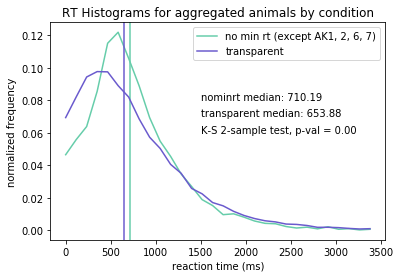

In [284]:
# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in nominrt_success_RTs_clean.values() for item in sublist])
x2 = np.array([item for sublist in transp_success_RTs_clean.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
plt.plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'no min rt (except AK1, 2, 6, 7)')
plt.axvline(np.median(x1), color = 'mediumaquamarine')
s = ('nominrt median: %.2f' %np.median(x1))
plt.text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
plt.plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'transparent')
plt.axvline(np.median(x2), color = 'slateblue')
s = ('transparent median: %.2f' %np.median(x2))
plt.text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
plt.text(1500, 0.06, s)

plt.legend()
# plt.ylim(0, 0.0016)
plt.xlabel('reaction time (ms)')
plt.ylabel('normalized frequency')
plt.title('RT Histograms for aggregated animals by condition')
# plt.savefig('RT_Histogram_success_RTs_nominrt_v_transp_only.pdf')

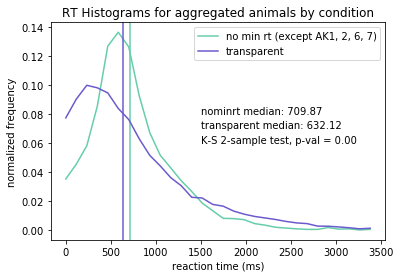

In [134]:
# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in nominrt_success_RTs_clean.values() for item in sublist])
x2 = np.array([item for sublist in transp_success_RTs_clean.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
plt.plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'no min rt (except AK1, 2, 6, 7)')
plt.axvline(np.median(x1), color = 'mediumaquamarine')
s = ('nominrt median: %.2f' %np.median(x1))
plt.text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
plt.plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'transparent')
plt.axvline(np.median(x2), color = 'slateblue')
s = ('transparent median: %.2f' %np.median(x2))
plt.text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
plt.text(1500, 0.06, s)

plt.legend()
# plt.ylim(0, 0.0016)
plt.xlabel('reaction time (ms)')
plt.ylabel('normalized frequency')
plt.title('RT Histograms for aggregated animals by condition')
# plt.savefig('RT_Histogram_success_RTs_nominrt_v_transp_only.pdf')

In [80]:
ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
print 'ks_stat:', ks_stat_12
print 'p_val:', p_val_12

ks_stat: 0.146114649416
p_val: 1.70537789251e-79


In [285]:
transp_vin_RTs_clean.keys()

['AK7_transparent0.0',
 'AK11_transparent0.0',
 'AK3_transparent0.0',
 'AK1_transparent0.0',
 'AK6_transparent0.0']

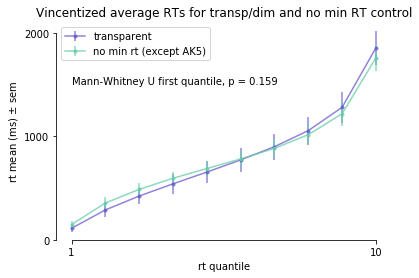

In [295]:
# compare nominrt and transp

x1 = [i+1 for i in range(len(nominrt_vin_RTs_clean_mean))]
y1 = nominrt_vin_RTs_clean_mean
yerr1 = nominrt_vin_RTs_clean_sem
label1 = 'no min rt (except AK5)'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(transp_vin_RTs_clean_mean))]
y2 = transp_vin_RTs_clean_mean
yerr2 = transp_vin_RTs_clean_sem
label2 = 'transparent'
color2 = 'slateblue'

plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)
plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)

plt.ylim(0,2100)
plt.yticks([0,1000,2000])
plt.xticks([1,10])
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(nominrt_vin_RTs_clean_list)[0], np.transpose(transp_vin_RTs_clean_list)[0])[1]
plt.text(1, 1500, s)
plt.title('Vincentized average RTs for transp/dim and no min RT control')
plt.legend()
sns.despine(trim=True)
# plt.savefig('AK_AL_nominrt_transp_only_no_dim_vincentized_RTs.pdf')

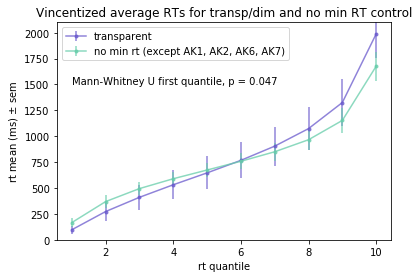

In [64]:
# compare nominrt and transp

x1 = [i+1 for i in range(len(nominrt_vin_RTs_clean_mean))]
y1 = nominrt_vin_RTs_clean_mean
yerr1 = nominrt_vin_RTs_clean_sem
label1 = 'no min rt (except AK1, AK2, AK6, AK7)'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(transp_vin_RTs_clean_mean))]
y2 = transp_vin_RTs_clean_mean
yerr2 = transp_vin_RTs_clean_sem
label2 = 'transparent'
color2 = 'slateblue'

plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)
plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)

plt.ylim(0,2100)
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(nominrt_vin_RTs_clean_list)[0], np.transpose(transp_vin_RTs_clean_list)[0])[1]
plt.text(1, 1500, s)
plt.title('Vincentized average RTs for transp/dim and no min RT control')
plt.legend()
# plt.savefig('AK_AL_nominrt_transp_only_no_dim_vincentized_RTs.pdf')

In [275]:
transp_failure_firstsesh_RTs_clean.keys()

['AK7_transparent0.0',
 'AK10_transparent0.1',
 'AK3_transparent0.0',
 'AK1_transparent0.0',
 'AK9_transparent0.1',
 'AK11_transparent0.0',
 'AK2_transparent0.1',
 'AK6_transparent0.0']

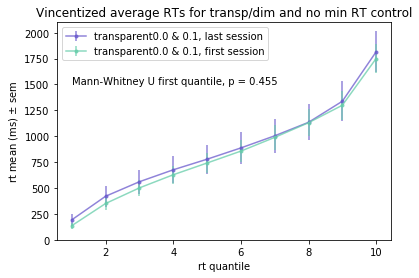

In [66]:
# compare nominrt and transp

x1 = [i+1 for i in range(len(transp_vin_firstsesh_RTs_mean))]
y1 = transp_vin_firstsesh_RTs_mean
yerr1 = transp_vin_firstsesh_RTs_sem
label1 = 'transparent0.0 & 0.1, first session'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(transp_vin_lastsesh_RTs_mean))]
y2 = transp_vin_lastsesh_RTs_mean
yerr2 = transp_vin_lastsesh_RTs_sem
label2 = 'transparent0.0 & 0.1, last session'
color2 = 'slateblue'

plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)
plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)

plt.ylim(0,2100)
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_firstsesh_RTs_list)[2], np.transpose(transp_vin_lastsesh_RTs_list)[2])[1]
plt.text(1, 1500, s)
plt.title('Vincentized average RTs for transp/dim and no min RT control')
plt.legend()
# plt.savefig('AK_AL_nominrt_transp_only_no_dim_vincentized_RTs.pdf')

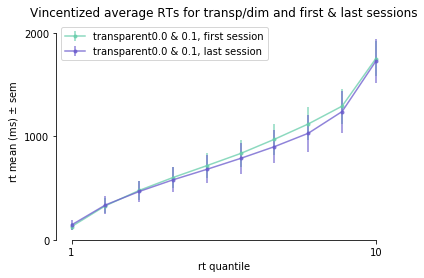

In [164]:
# compare nominrt and transp

x1 = [i+1 for i in range(len(transp_vin_firstsesh_RTs_clean_mean))]
y1 = transp_vin_firstsesh_RTs_clean_mean
yerr1 = transp_vin_firstsesh_RTs_clean_sem
label1 = 'transparent0.0 & 0.1, first session'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(transp_vin_lastsesh_RTs_clean_mean))]
y2 = transp_vin_lastsesh_RTs_clean_mean
yerr2 = transp_vin_lastsesh_RTs_clean_sem
label2 = 'transparent0.0 & 0.1, last session'
color2 = 'slateblue'

plt.errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)
plt.errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)

plt.ylim(0,2100)
plt.yticks([0,1000,2000])
plt.xticks([1,10])
plt.xlabel('rt quantile')
plt.ylabel('rt mean (ms) $\pm$ sem')
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_firstsesh_RTs_clean_list)[8], np.transpose(transp_vin_lastsesh_RTs_clean_list)[8])[1]
# plt.text(1, 1500, s)
plt.title('Vincentized average RTs for transp/dim and first & last sessions')
plt.legend()

sns.despine(trim=True)
# plt.savefig('AK_AL_nominrt_transp_only_no_dim_vincentized_RTs.pdf')

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Passing `normed=

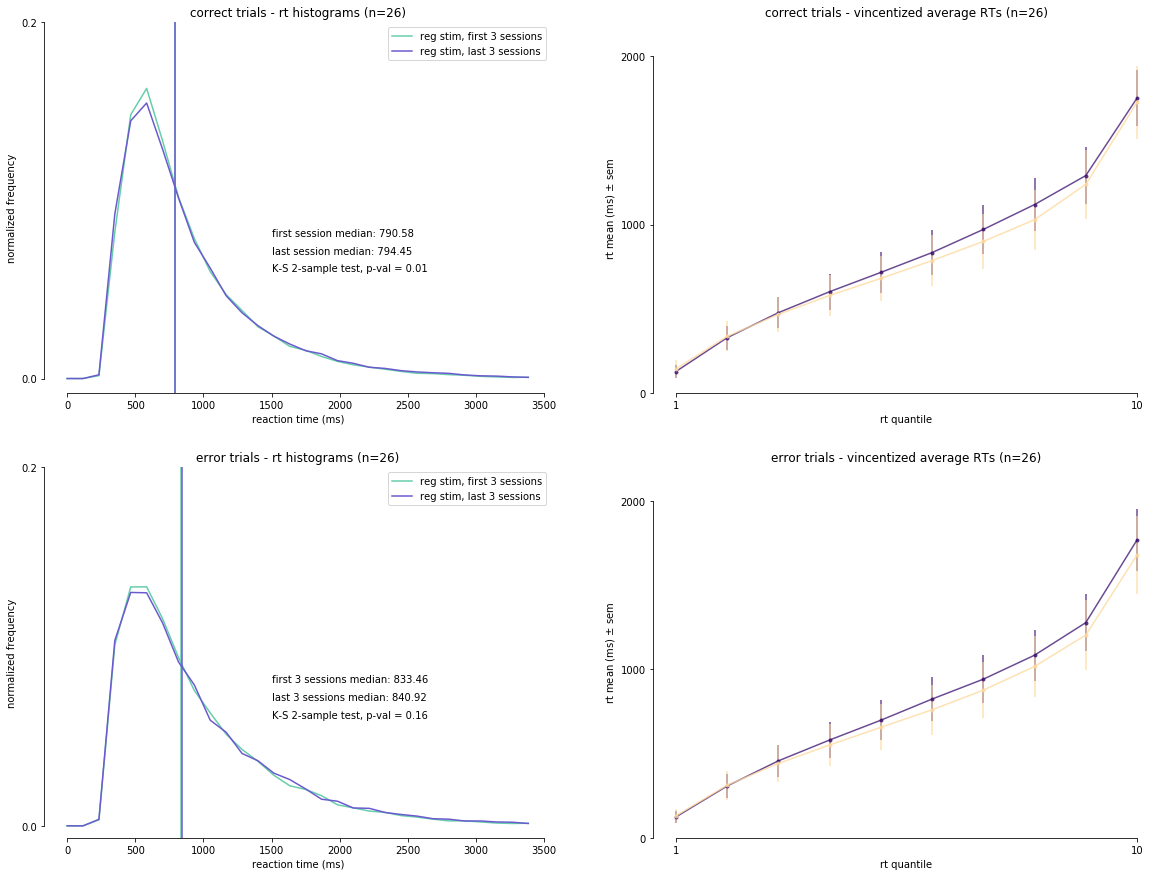

In [302]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

# ~~~~~ success (correct) trials ~~~~


# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in reg_success_RTs_early.values() for item in sublist])
x2 = np.array([item for sublist in reg_success_RTs_late.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'reg stim, first 3 sessions')
ax[0,0].axvline(np.median(x1), color = 'mediumaquamarine')
s = ('first session median: %.2f' %np.median(x1))
ax[0,0].text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'reg stim, last 3 sessions')
ax[0,0].axvline(np.median(x2), color = 'slateblue')
s = ('last session median: %.2f' %np.median(x2))
ax[0,0].text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
ax[0,0].text(1500, 0.06, s)

ax[0,0].legend()
ax[0,0].set_yticks([0,0.2])
ax[0,0].set_xticks([0,500,1000,1500,2000,2500,3000,3500])
ax[0,0].set_xlabel('reaction time (ms)')
ax[0,0].set_ylabel('normalized frequency')
ax[0,0].set_title('correct trials - rt histograms (n=26)')
# plt.savefig('RT_Histogram_success_RTs_nominrt_v_transp_only.pdf')


# Plot vincentized RTs of aggregated data for each group

x1 = [i+1 for i in range(len(transp_vin_first2sesh_RTs_clean_mean))]
y1 = transp_vin_first2sesh_RTs_clean_mean
yerr1 = transp_vin_first2sesh_RTs_clean_sem
label1 = 'reg stim, first 3 sessions'
color1 = plt.cm.magma(50)

x2 = [i+1 for i in range(len(transp_vin_last2sesh_RTs_clean_mean))]
y2 = transp_vin_last2sesh_RTs_clean_mean
yerr2 = transp_vin_last2sesh_RTs_clean_sem
label2 = 'reg stim, last 3 sessions'
color2 = plt.cm.magma(235)

ax[0,1].errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)
ax[0,1].errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)

ax[0,1].set_ylim(0,2200)
ax[0,1].set_yticks([0,1000,2000])
ax[0,1].set_xticks([1,10])
ax[0,1].set_xlabel('rt quantile')
ax[0,1].set_ylabel('rt mean (ms) $\pm$ sem')
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_firstsesh_RTs_clean_list)[8], np.transpose(transp_vin_lastsesh_RTs_clean_list)[8])[1]
# plt.text(1, 1500, s)
ax[0,1].set_title('correct trials - vincentized average RTs (n=26)')
# ax[0,1].legend()



# ~~~~~ failure (error) trials ~~~~


# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in reg_failure_RTs_early.values() for item in sublist])
x2 = np.array([item for sublist in reg_failure_RTs_late.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'reg stim, first 3 sessions')
ax[1,0].axvline(np.median(x1), color = 'mediumaquamarine')
s = ('first 3 sessions median: %.2f' %np.median(x1))
ax[1,0].text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'reg stim, last 3 sessions')
ax[1,0].axvline(np.median(x2), color = 'slateblue')
s = ('last 3 sessions median: %.2f' %np.median(x2))
ax[1,0].text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
ax[1,0].text(1500, 0.06, s)

ax[1,0].legend()
ax[1,0].set_yticks([0,0.2])
ax[1,0].set_xticks([0,500,1000,1500,2000,2500,3000,3500])
ax[1,0].set_xlabel('reaction time (ms)')
ax[1,0].set_ylabel('normalized frequency')
ax[1,0].set_title('error trials - rt histograms (n=26)')
# plt.savefig('RT_Histogram_failure_RTs_nominrt_v_transp_only.pdf')


# Plot vincentized RTs of aggregated data for each group

x1 = [i+1 for i in range(len(transp_vin_failure_first2sesh_RTs_clean_mean))]
y1 = transp_vin_failure_first2sesh_RTs_clean_mean
yerr1 = transp_vin_failure_first2sesh_RTs_clean_sem
label1 = 'reg stim, first 3 sessions'
color1 = plt.cm.magma(50)

x2 = [i+1 for i in range(len(transp_vin_failure_last2sesh_RTs_clean_mean))]
y2 = transp_vin_failure_last2sesh_RTs_clean_mean
yerr2 = transp_vin_failure_last2sesh_RTs_clean_sem
label2 = 'reg stim, last 3 sessions'
color2 = plt.cm.magma(235)

ax[1,1].errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)
ax[1,1].errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)

ax[1,1].set_ylim(0,2200)
ax[1,1].set_yticks([0,1000,2000])
ax[1,1].set_xticks([1,10])
ax[1,1].set_xlabel('rt quantile')
ax[1,1].set_ylabel('rt mean (ms) $\pm$ sem')
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_failure_firstsesh_RTs_clean_list)[8], np.transpose(transp_vin_failure_lastsesh_RTs_clean_list)[8])[1]
# plt.text(1, 1500, s)
ax[1,1].set_title('error trials - vincentized average RTs (n=26)')
# ax[1,1].legend()


sns.despine(trim=True)
# fig.savefig('AK_AL_regstim_first3_and_last3_sesh_vincentized_RTs.pdf')

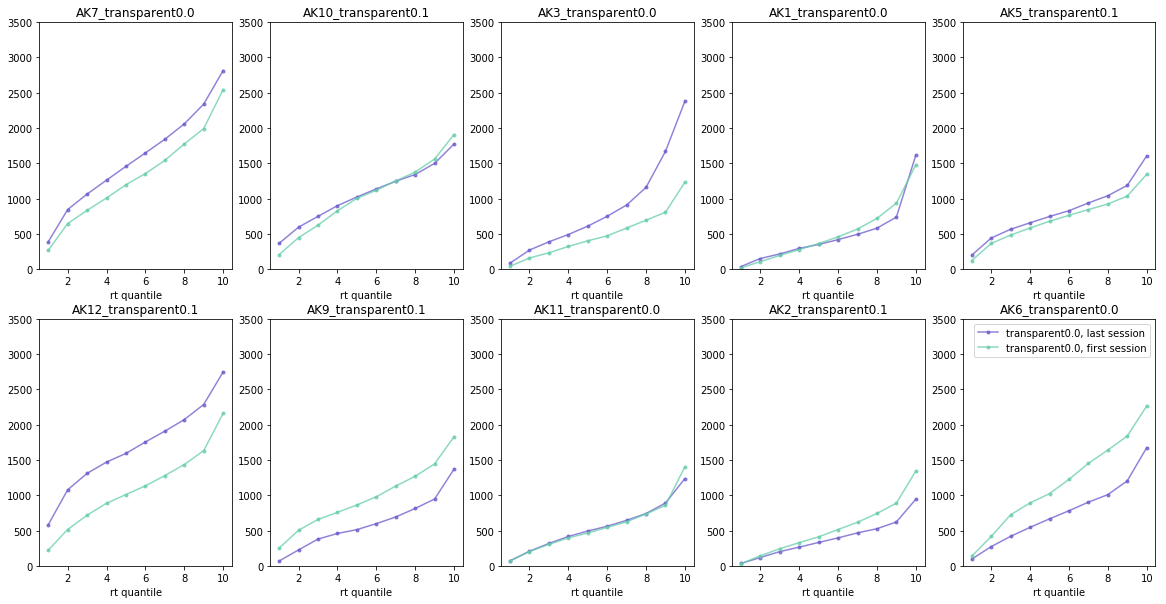

In [148]:
# compare nominrt and transp

fig, ax = plt.subplots(2,5, figsize = (20,10))

for animal in range(10):
    name = transp_vin_firstsesh_RTs.keys()[animal]
    x1 = [i+1 for i in range(len(transp_vin_firstsesh_RTs_list[animal]))]
    y1 = transp_vin_firstsesh_RTs_list[animal]
    label1 = 'transparent0.0, first session'
    color1 = 'mediumaquamarine'

    x2 = [i+1 for i in range(len(transp_vin_lastsesh_RTs_list[animal]))]
    y2 = transp_vin_lastsesh_RTs_list[animal]
    label2 = 'transparent0.0, last session'
    color2 = 'slateblue'

    if animal < 5:
        row = 0
        adj = 0
    else:
        row = 1
        adj = 5
    ax[row,animal-adj].plot(x2, y2, color = color2, marker = '.', label = label2, alpha = 0.75)
    ax[row,animal-adj].plot(x1, y1, color = color1, marker = '.', label = label1, alpha = 0.75)

    ax[row,animal-adj].set_ylim(0,3500)
    ax[row,animal-adj].set_xlabel('rt quantile')
#     ax[row,animal-adj].set_ylabel('rt mean (ms) $\pm$ sem')
    ax[row,animal-adj].set_title(name)

        
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_firstsesh_RTs_clean_list)[0], np.transpose(transp_vin_lastsesh_RTs_clean_list)[0])[1]
# plt.text(1, 1500, s)
# plt.title('Vincentized average RTs for transp/dim and no min RT control')
plt.legend()
# plt.savefig('AK_AL_nominrt_transp_only_no_dim_vincentized_RTs.pdf')

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Passing `normed=

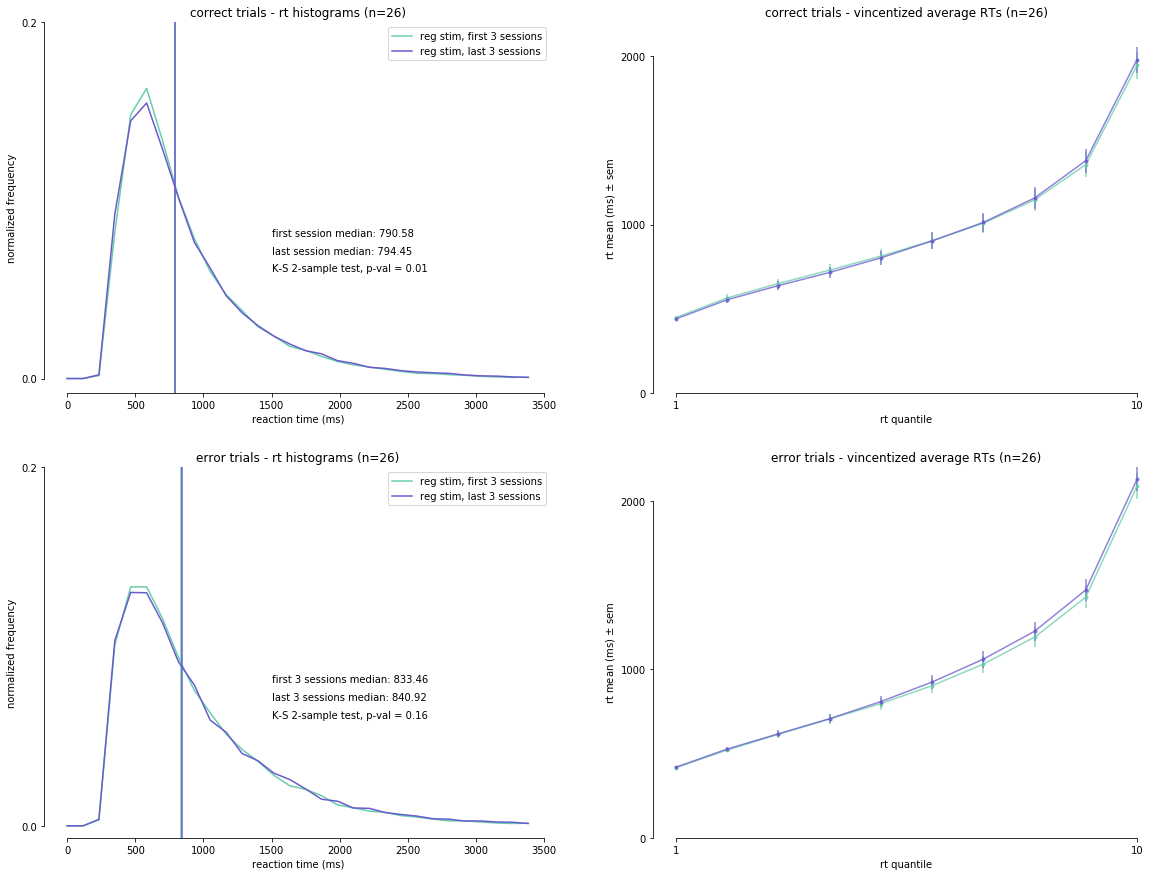

In [265]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

# ~~~~~ success (correct) trials ~~~~


# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in reg_success_RTs_early.values() for item in sublist])
x2 = np.array([item for sublist in reg_success_RTs_late.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'reg stim, first 3 sessions')
ax[0,0].axvline(np.median(x1), color = 'mediumaquamarine')
s = ('first session median: %.2f' %np.median(x1))
ax[0,0].text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'reg stim, last 3 sessions')
ax[0,0].axvline(np.median(x2), color = 'slateblue')
s = ('last session median: %.2f' %np.median(x2))
ax[0,0].text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
ax[0,0].text(1500, 0.06, s)

ax[0,0].legend()
ax[0,0].set_yticks([0,0.2])
ax[0,0].set_xticks([0,500,1000,1500,2000,2500,3000,3500])
ax[0,0].set_xlabel('reaction time (ms)')
ax[0,0].set_ylabel('normalized frequency')
ax[0,0].set_title('correct trials - rt histograms (n=26)')
# plt.savefig('RT_Histogram_success_RTs_nominrt_v_transp_only.pdf')


# Plot vincentized RTs of aggregated data for each group

x1 = [i+1 for i in range(len(reg_vin_success_RTs_early_mean))]
y1 = reg_vin_success_RTs_early_mean
yerr1 = reg_vin_success_RTs_early_sem
label1 = 'reg stim, first 3 sessions'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(reg_vin_success_RTs_late_mean))]
y2 = reg_vin_success_RTs_late_mean
yerr2 = reg_vin_success_RTs_late_sem
label2 = 'reg stim, last 3 sessions'
color2 = 'slateblue'

ax[0,1].errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)
ax[0,1].errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)

ax[0,1].set_ylim(0,2200)
ax[0,1].set_yticks([0,1000,2000])
ax[0,1].set_xticks([1,10])
ax[0,1].set_xlabel('rt quantile')
ax[0,1].set_ylabel('rt mean (ms) $\pm$ sem')
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_firstsesh_RTs_clean_list)[8], np.transpose(transp_vin_lastsesh_RTs_clean_list)[8])[1]
# plt.text(1, 1500, s)
ax[0,1].set_title('correct trials - vincentized average RTs (n=26)')
# ax[0,1].legend()



# ~~~~~ failure (error) trials ~~~~


# Plot histogram of aggregated data for each group

range_ = (0, 3500)
n_bins = 30
alpha = 1
normed = True
cumulative = False

x1 = np.array([item for sublist in reg_failure_RTs_early.values() for item in sublist])
x2 = np.array([item for sublist in reg_failure_RTs_late.values() for item in sublist])

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'reg stim, first 3 sessions')
ax[1,0].axvline(np.median(x1), color = 'mediumaquamarine')
s = ('first 3 sessions median: %.2f' %np.median(x1))
ax[1,0].text(1500, 0.08, s)

hist2, bins2 = np.histogram(x2, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins2[:-1], hist2*(range_[1]/n_bins), color = 'slateblue', label = 'reg stim, last 3 sessions')
ax[1,0].axvline(np.median(x2), color = 'slateblue')
s = ('last 3 sessions median: %.2f' %np.median(x2))
ax[1,0].text(1500, 0.07, s)

ks_stat_12, p_val_12 = stats.ks_2samp(x1, x2)
s = ('K-S 2-sample test, p-val = %.2f' %p_val_12)
ax[1,0].text(1500, 0.06, s)

ax[1,0].legend()
ax[1,0].set_yticks([0,0.2])
ax[1,0].set_xticks([0,500,1000,1500,2000,2500,3000,3500])
ax[1,0].set_xlabel('reaction time (ms)')
ax[1,0].set_ylabel('normalized frequency')
ax[1,0].set_title('error trials - rt histograms (n=26)')
# plt.savefig('RT_Histogram_failure_RTs_nominrt_v_transp_only.pdf')


# Plot vincentized RTs of aggregated data for each group

x1 = [i+1 for i in range(len(reg_vin_failure_RTs_early_mean))]
y1 = reg_vin_failure_RTs_early_mean
yerr1 = reg_vin_failure_RTs_early_sem
label1 = 'reg stim, first 3 sessions'
color1 = 'mediumaquamarine'

x2 = [i+1 for i in range(len(reg_vin_failure_RTs_late_mean))]
y2 = reg_vin_failure_RTs_late_mean
yerr2 = reg_vin_failure_RTs_late_sem
label2 = 'reg stim, last 3 sessions'
color2 = 'slateblue'

ax[1,1].errorbar(x = x1, y = y1, yerr = yerr1, color = color1, marker = '.', label = label1, alpha = 0.75)
ax[1,1].errorbar(x = x2, y = y2, yerr = yerr2, color = color2, marker = '.', label = label2, alpha = 0.75)

ax[1,1].set_ylim(0,2200)
ax[1,1].set_yticks([0,1000,2000])
ax[1,1].set_xticks([1,10])
ax[1,1].set_xlabel('rt quantile')
ax[1,1].set_ylabel('rt mean (ms) $\pm$ sem')
# s = 'Mann-Whitney U first quantile, p = %.3f'  % stats.mannwhitneyu(np.transpose(transp_vin_failure_firstsesh_RTs_clean_list)[8], np.transpose(transp_vin_failure_lastsesh_RTs_clean_list)[8])[1]
# plt.text(1, 1500, s)
ax[1,1].set_title('error trials - vincentized average RTs (n=26)')
# ax[1,1].legend()


sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first3_and_last3_sesh_vincentized_RTs.pdf')